In [1]:
#Importing the standard libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importing the solver modules
import system
from obe import obe
from states import SigmaLevel,PiLevelParity
from obe import Excitation
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
b=system.System([],[]) 
#Since the program is designed mailnly to address the states of a BaF molecule, it expects the rotational and the angular momentum states when defining the system
#We will generate a ground state first. In a BaF molecule it is a Sigma level
b.sigma_states.append(SigmaLevel(0.5,0,1/2,1,-1))     #state0
b.sigma_states.append(SigmaLevel(0.5,0,1/2,1,1))     #state1
b.sigma_states.append(SigmaLevel(0.5,0,1/2,1,0))     #state1
#The excited state is a Pi level
b.pi_states.append(PiLevelParity(-1,1/2,1/2,0,0))    #state2


In [4]:
## To evaluate the matrix element manually
from hamiltonian import H_int
g0 = b.sigma_states[0]
g1 = b.sigma_states[1]
g2 = b.sigma_states[2]
e0 = b.pi_states[0]
H_int(g1,e0,pol = -1) #the acutal value of the dipole matrix element is this number multiplied by <sigma|d|pi>. It is useful to define the relative but not absolute strength of transitions



0.272165526975909*sqrt(3)

In [5]:
#Next we will generate the Hamiltonian for this two level system
b.sigma_Hamiltonian.generate_bare()
b.pi_Hamiltonian.generate_bare()
b.sigma_Hamiltonian.diagonalize()
b.pi_Hamiltonian.diagonalize()

3


In [6]:
G = b.sigma_Hamiltonian.diagonalized_states
GH = b.sigma_Hamiltonian.diagonalized_Hamiltonian
E =b.pi_Hamiltonian.diagonalized_states
EH = b.pi_Hamiltonian.diagonalized_Hamiltonian
BR = b.generate_branching_ratios(G,E)

Pi branching took : 3.5041630268096924 sec
Sigma- branching took : 0.33836793899536133 sec
Sigma+ branching took : 0.30428504943847656 sec


In [7]:
b.branching_ratios

array([[0.33333333],
       [0.33333333],
       [0.33333333]])

In [8]:
H0 = np.zeros((len(G)+len(E),len(G)+len(E)))
H0[0:len(G),0:len(G)] = GH
H0[len(G):,len(G):] = EH

#Introduce interaction with sigma+ polarized light
b.generate_interaction_Hamiltonian(G,E,pol=1)
Hint_plus = b.interaction_Hamiltonian

#Introduce interaction with sigma- polarized light
b.generate_interaction_Hamiltonian(G,E,pol=-1)
Hint_minus = b.interaction_Hamiltonian

n0 = [1/len(G)]*len(G)+[0]*len(E)
Hint_plus

array([[0.        +0.j, 0.        +0.j, 0.        +0.j, 0.47140452+0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.47140452-0.j, 0.        -0.j, 0.        -0.j, 0.        +0.j]])

In [9]:
H0

array([[1.64623683e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.64623683e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.64623683e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.48665795e+08]])

In [10]:
Gamma = 2*np.pi*2.7


#### Demonstrating STIRAP in three level system

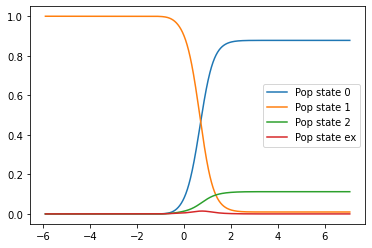

In [12]:
rabi_probe = 5.0 
rabi_control = 5.0
tsigma = 10/Gamma

#Assuming that the population is in G[1] state and we want to move it all to G[0] state
r_init = np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]]).astype(np.complex128)
#Counterintuitive sequence of pulse
field1 = Excitation(rabi_probe,1,G[0],E[0],0,position=0, diameter=tsigma*4,shape = "Gaussian")
field2 = Excitation(rabi_control,-1,G[1],E[0],0,position=2*tsigma, diameter=tsigma*4,shape = "Gaussian")
field = [field1,field2]

steps = 1000
my_obe = obe(field,[G,E],H0,[Hint_plus, Hint_minus],b.branching_ratios)
t,ans = my_obe.solve(steps,r_init,max_step_size = 1/Gamma)
pop_0 = ans[:,0]
pop_1 = ans[:,5]
plt.plot(t,pop_0,label = 'Pop state 0');
plt.plot(t,pop_1,label = 'Pop state 1');
pop_2 = ans[:,10]
pop_ex = ans[:,15]
plt.plot(t,pop_2,label = 'Pop state 2');
plt.plot(t,pop_ex,label = 'Pop state ex');

#pulse shape
def gaussian(x,x0,wid):
    return np.exp(-(x-x0)**2/2/wid**2)
t = np.linspace(-2.5*tsigma*4,2*tsigma*4,100)
probe = gaussian(t,0,np.sqrt(2)*tsigma)
control = gaussian(t,2*tsigma,np.sqrt(2)*tsigma)
# plt.plot(t,probe,'--r',label="Probe beam")
# plt.plot(t,control,'--g',label="Control beam")
plt.legend();